In [1]:
import json
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc

from dredFISH.Design.model_v2p1_norm import CellTypeNet
from dredFISH.Design import data_loader_scrna 
importlib.reload(data_loader_scrna)

<module 'dredFISH.Design.data_loader_scrna' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/data_loader_scrna.py'>

In [2]:
def get_mse_torch(tnsr_true, tnsr_pred=[]):
    """Mean (over rows) squared error
    if no pred, returns the variance.
    """
    if len(tnsr_pred):
        mse = (tnsr_true - tnsr_pred).square().mean(axis=0)
    else:
        mse = (tnsr_true - tnsr_true.mean(axis=0)).square().mean(axis=0)
    return mse
        
def get_r2_torch(tnsr_true, tnsr_pred, zero_tol=1e-10):
    """
    """
    mse = get_mse_torch(tnsr_true, tnsr_pred)
    var = get_mse_torch(tnsr_true)
    r2 = 1-mse/torch.clamp(var, min=zero_tol)
    return r2

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
def plot0(pmat):
    """
    """
    pm = sns.color_palette('husl', n_colors=pmat.shape[1])
    
    fig, ax = plt.subplots(figsize=(8,6))
    for i, col in enumerate(pmat):
        _x = pmat[col]
        _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
        ax.plot(_x, color=pm[i], label=f'{i+1}')

    ax.set_yscale('log')
    ax.set_xlabel('Gene (ordered by weights)')
    ax.set_ylabel('Weight (# of probes)')
    sns.despine(ax=ax)
    ax.set_title('DPNMF matrix structure')
    ax.legend(ncol=3, title='measurements')
    
    return 

def plot1(pospmat):
    """
    """
    with sns.axes_style('ticks'):
        # zero count does not matter
        bpmat = (pospmat > 0).astype(int)

        _mat, _row, _col = basicu.diag_matrix_rows(bpmat.values)
        _zeromat = pmat[pmat.sum(axis=1) == 0]
        nmat = len(_mat)
        nzeromat = len(_zeromat)
        ntotal = nmat + nzeromat

        fig, ax = plt.subplots(figsize=(6,8))
        sns.heatmap(pd.DataFrame(np.vstack([_mat, _zeromat]), columns=(_col+1)),
                    cbar=False,
                    xticklabels=5, 
                    cmap='rocket_r',
                    ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        ax.set_yticks([nmat, ntotal])
        ax.text(0, nmat, nmat, ha='right')
        ax.text(0, ntotal, ntotal, ha='right')

        ax.axhline(nmat, color='gray')
        ax.vlines(np.arange(0,24,5), 0, ntotal, color='gray', linewidth=0.5)
        ax.set_xlabel('Measurements')
        ax.set_ylabel(f'Genes', rotation=0, ha='right')
        ax.set_title('Genes with any weights')
        plt.show()
        
    return

def plot2(fpmat):
    """
    """
    with sns.axes_style('ticks'):
        _mat, _row, _col = basicu.diag_matrix_rows(fpmat.values)
        nmat = len(_mat)

        fig, ax = plt.subplots(figsize=(6,8))
        sns.heatmap(pd.DataFrame(_mat, columns=_col+1), 
                    xticklabels=5, 
                    cmap='rocket_r',
                    ax=ax, vmax=0.01, cbar_kws=dict(shrink=0.5, label='weight proportion')
                   )
        ax.set_xlabel('Basis')
        ax.set_ylabel('Genes')
        ax.set_yticks([nmat])
        ax.text(0, nmat, nmat, ha='right')
        plt.show()
        


In [4]:
def plot_enc(pmat, fpmat):
    """
    """
    pm = sns.color_palette('husl', n_colors=pmat.shape[1])
    
    with sns.axes_style('ticks'):
        fig = plt.figure(figsize=(15,6))
        ax_dict = fig.subplot_mosaic("AACBBB")
        ax = ax_dict['A']
        # fig, ax = plt.subplots(figsize=(6,8))
        _mat, _row, _col = basicu.diag_matrix_rows(fpmat.values)
        nmat = len(_mat)
        sns.heatmap(pd.DataFrame(_mat, columns=_col+1), 
                    xticklabels=5, 
                    cmap='rocket_r',
                    ax=ax, 
                    vmax=0.01, 
                    cbar_kws=dict(shrink=0.3, label='Weight prop.', ticks=[0,0.01], aspect=10,),
                   )
        ax.set_xlabel('Basis')
        ax.set_ylabel('Genes')
        ax.set_yticks([nmat])
        ax.text(0, nmat, nmat, ha='right')
        
        ax = ax_dict['B']
        for i, col in enumerate(pmat):
            _x = pmat[col]
            _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
            ax.plot(_x, color=pm[i], label=f'{i+1}')

        ax.set_yscale('log')
        ax.set_xlabel('Genes')
        ax.set_ylabel('Weight')
        sns.despine(ax=ax)
        ax.set_title('Encoding matrix')
        ax.legend(ncol=3, title='Basis')
        
        ax_dict['C'].axis('off')
        plt.show()
    return 

def plot_intn(prjx):
    """
    # intensity across bits
    """
    fig = plt.figure(figsize=(12,4))
    ax_dict = fig.subplot_mosaic("AAABB")
    ax = ax_dict['A']
    sns.boxplot(data=prjx, ax=ax, color='gray', fliersize=2, width=0.7)
    ax.set_title('Intensities')
    ax.set_yscale('log')
    sns.despine(ax=ax)

    ax = ax_dict['B']
    prjx_medbits = np.median(prjx, axis=0)
    prjx_q10bits = np.percentile(prjx, 10, axis=0)
    prjx_q90bits = np.percentile(prjx, 90, axis=0)
    order = np.argsort(prjx_medbits)[::-1]
    
    ax.plot(prjx_medbits[order], '-o', markersize=5, label='median')
    ax.plot(prjx_q10bits[order], '-o', markersize=5, label='10 perctl.')
    ax.plot(prjx_q90bits[order], '-o', markersize=5, label='90 perctl.')
    
    ax.set_xticks(np.arange(len(prjx_medbits)))
    ax.set_title('Median Intensity across bits\n(re-ordered)')
    ax.set_yscale('log')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1))

    fig.subplots_adjust(wspace=0.4)
    plt.show()
    
    return

def plot_embx_clsts(prjx_clsts, embx_clsts, embx_clsts_z, _rows, _cols):
    """
    Projection matrix (Z)
    Embedded matrix (Z_norm)
    zscored
    
    rows, cols
    
    """
    fig, axs = plt.subplots(1,3,figsize=(3*4,1*8))
    cbar_kws = dict(shrink=0.7, orientation='horizontal', fraction=0.02, pad=0.15)
    ax = axs[0]
    sns.heatmap(np.log10(prjx_clsts)[_rows][:,_cols], 
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                ax=ax,
               )
    ax.set_title('log(Z)')
    ax.set_xlabel('Basis')
    ax.set_ylabel('Cell types')

    ax = axs[1]
    sns.heatmap(embx_clsts[_rows][:,_cols], 
                yticklabels=False,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                ax=ax,
               )
    ax.set_title('Z_norm')

    ax = axs[2]
    sns.heatmap(embx_clsts_z[_rows][:,_cols], 
                yticklabels=False,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                ax=ax,
               )
    ax.set_title('Z_norm - zscored per bit')
    fig.subplots_adjust(wspace=0.05)
    plt.show()

def plot_heatcorr(embx_clsts_corr): 
    """clst-clst corr
    """
    
    vmin = 0.5
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    cbar_ax = fig.add_axes([0.9, 0.3, 0.01, 0.4])
    sns.heatmap(embx_clsts_corr, 
                xticklabels=False, 
                yticklabels=False, 
                cbar_ax=cbar_ax,
                cbar_kws=dict(label='Pearson corr.', 
                              # ticks=[0.5, 0.75, 1],
                              aspect=5,
                             ),
                cmap='rocket_r',
                ax=ax, 
                vmin=vmin,
               )
    ax.set_xlabel('Known cell types')
    ax.set_ylabel('Known cell types')
    ax.set_aspect('equal')
    ax.set_title('')

    # powerplots.savefig_autodate(fig, os.path.join(fig_dir, "NN_DPNMF_correlation_matrix.pdf"))
    plt.show()

# data

In [5]:
studybatch = 'types_v22_Aug19_scale1.0e+07'
s0 = 1e7

In [6]:
rootdat_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/' 
glob.glob(f'{studybatch}*', root_dir=rootdat_dir)

['types_v22_Aug19_scale1.0e+07_lmd01.00e+00_nbit12_nrcn0_lr0.01',
 'types_v22_Aug19_scale1.0e+07_lmd01.00e+00_nbit24_nrcn0_lr0.01']

In [7]:
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=500,
)
gsubidx = torch.load(
    os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_sub140_smrt_v1.pt')
)

n_gns = trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
# cnstrnts = torch.tensor(trn_dataloader.dataset.data['num_probe_limit'])

In [8]:
nbits = [12, 24] #[3,6,12,24] #,48,72,96]

mean_acc_all = []
n_acc_all = []

n_bits_acc = []

encx_all = []
prjx_all = []
embx_all = []
clsts_all = []

nrcn = 0
lr = 0.01
for nbit in nbits:
    print(nbit)
    
    dat_dir = rootdat_dir + f'{studybatch}_lmd01.00e+00_nbit{nbit}_nrcn{nrcn}_lr{lr}'
    print(os.path.isdir(dat_dir), dat_dir)

    # prep the model
    f = glob.glob(os.path.join(dat_dir, 'model*'))[0]

    reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3 = (os.path.basename(f)
                                                                            [len('model='):-len('.pt')]
                                                                            .replace('E-', 'expn').split('-')
                                                                     )
    lmd0 = 1
    mxpr = np.float64(mxpr)
    n_bit = int(n_bit)
    drprt = np.float64(drprt)
    # reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3
    n_rcn_layers = nrcn

    model= CellTypeNet(n_gns=     n_gns,                      
                       n_cat=     n_cat,                      
                       gsubidx= gsubidx,
                       n_rcn_layers=n_rcn_layers,
                       n_bit=     n_bit,                      # fixed
                       mxpr=      mxpr,
                       drprt=     drprt,
                       lmd0=      lmd0,
                       scale=     s0,
                       noise=     None,
                      )
    model.load_state_dict(torch.load(f, map_location=device))

    # evaluate
    model.eval()
    with torch.no_grad():
        # validation dataset
        ftrs, clsts = next(iter(tst_dataloader))
        ftrs = ftrs.float().to(device)
        clstsc = clsts.long().to(device)

        plgt_fine, ftrs_rcn, emb = model.forward(ftrs, rnd=True)
        prds_fine = plgt_fine.max(1)[1]
        fine_acc_eval = (prds_fine == clsts).float().mean()
        
        # break down
        tmp = pd.DataFrame()
        tmp[0] = (prds_fine == clsts).numpy()
        tmp[1] = clsts.numpy()
        mean_acc = tmp.groupby(1).mean().values.reshape(-1,)
        n_acc = tmp.groupby(1).size().values.reshape(-1,)

        # enc mat
        encx = model.enc.weight.exp()
        encx = (encx/encx.sum()*model.mxpr).round().detach() #.numpy()
        
        # get embedding 
        prjx = model.get_prj(ftrs, rnd=False)
        # get normed
        embx = model.get_emb(ftrs, rnd=False)
        
        print(f"acc: {fine_acc_eval}")
        encx_all.append(encx)
        prjx_all.append(prjx)
        embx_all.append(embx)
        clsts_all.append(clsts)
        n_bits_acc.append(fine_acc_eval)
        
        mean_acc_all.append(mean_acc)
        n_acc_all.append(n_acc)
        
        # break

12
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/types_v22_Aug19_scale1.0e+07_lmd01.00e+00_nbit12_nrcn0_lr0.01
acc: 0.8960000276565552
24
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/types_v22_Aug19_scale1.0e+07_lmd01.00e+00_nbit24_nrcn0_lr0.01
acc: 0.9639999866485596


In [9]:
scaleback = model.nrm.logscale.exp()
np.log10(scaleback.item())

6.999999869711636

### check overall performance

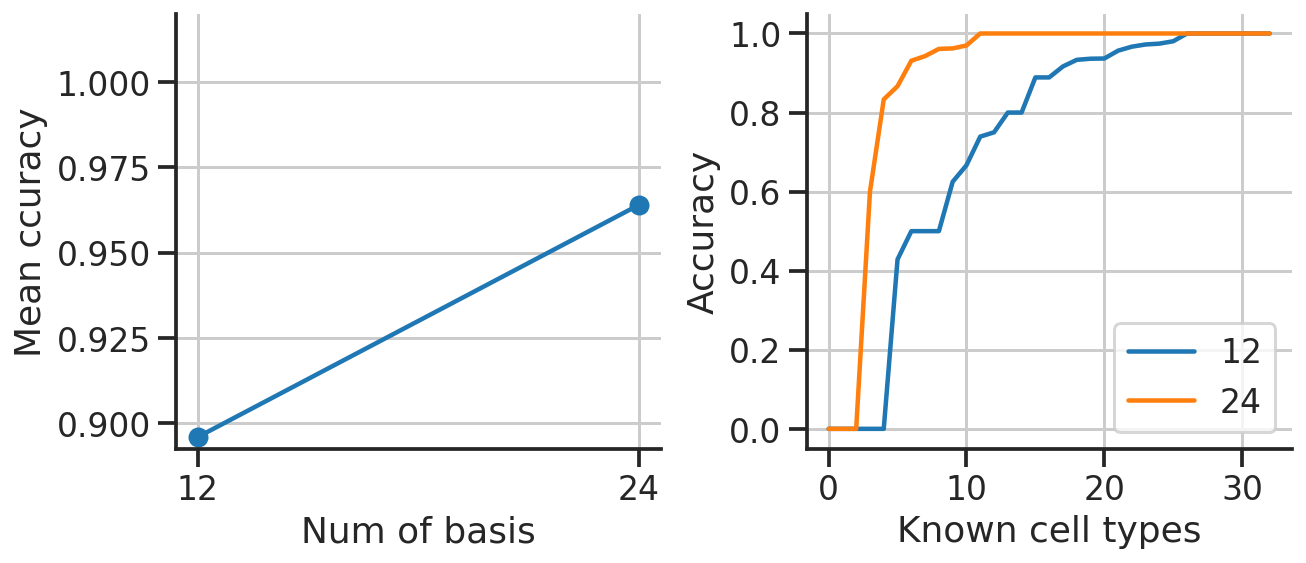

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
ax.plot(nbits, n_bits_acc, '-o')
ax.set_ylim(ymax=1.02) #[0,1.02])
ax.set_xticks(nbits)
ax.set_xlabel('Num of basis')
ax.set_ylabel('Mean ccuracy')
sns.despine(ax=ax)

ax = axs[1]
for nbit, mean_acc in zip(nbits, mean_acc_all):
    ax.plot(np.sort(mean_acc), label=nbit)
ax.set_xlabel('Known cell types')
ax.set_ylabel('Accuracy')
ax.legend()
sns.despine(ax=ax)
fig.subplots_adjust(wspace=0.3)
plt.show()

### check structures
- encoding
- projection
- embedding

In [11]:
encx = encx_all[1].numpy()
prjx = prjx_all[1].numpy()
embx = embx_all[1].numpy()
clsts = clsts_all[1].numpy()
encx.shape, prjx.shape, clsts.shape

((45768, 24), (500, 24), (500,))

In [12]:
pmat = pd.DataFrame(encx) #, index=genes)
nzero_prbe_cond = pmat.sum(axis=1) > 0
pospmat = pmat[nzero_prbe_cond]
fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)

prjx_clsts, _ = basicu.group_mean(prjx, clsts)
# prjx_clsts_z  = basicu.zscore(prjx_clsts, allow_nan=True, axis=0)
# prjx_clsts_corr = np.corrcoef(prjx_clsts_z)

embx_clsts, _ = basicu.group_mean(embx, clsts)
embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
embx_clsts_corr = np.corrcoef(embx_clsts_z)

# order by HC
_rows = order_by_hc(embx_clsts)
_cols = order_by_hc(embx_clsts.T)

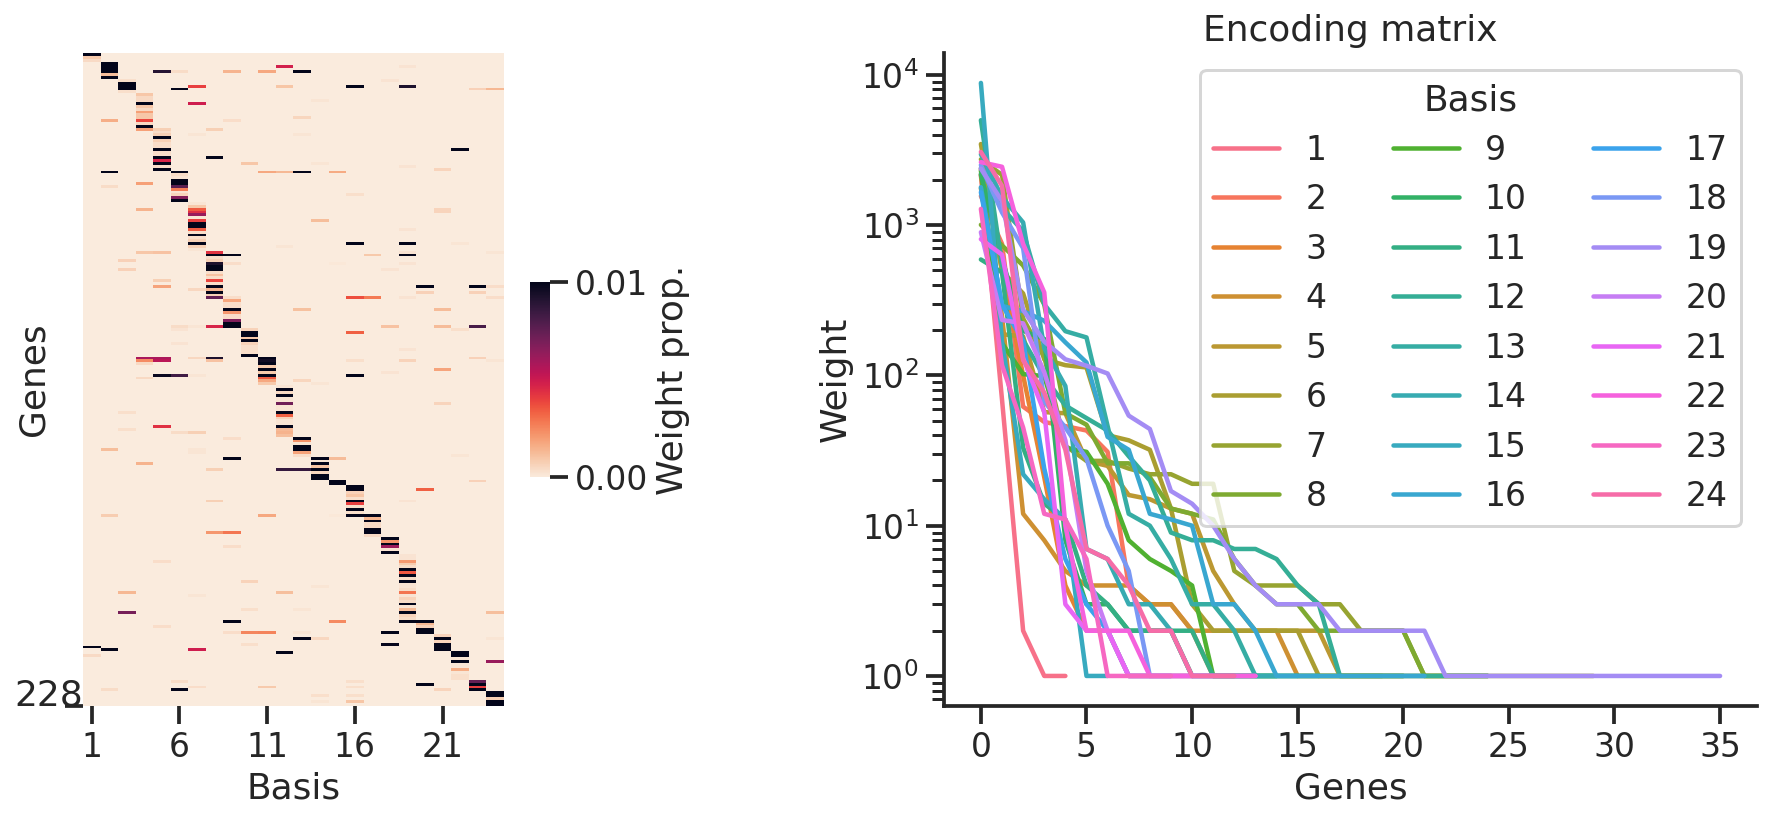

In [13]:
plot_enc(pmat, fpmat)

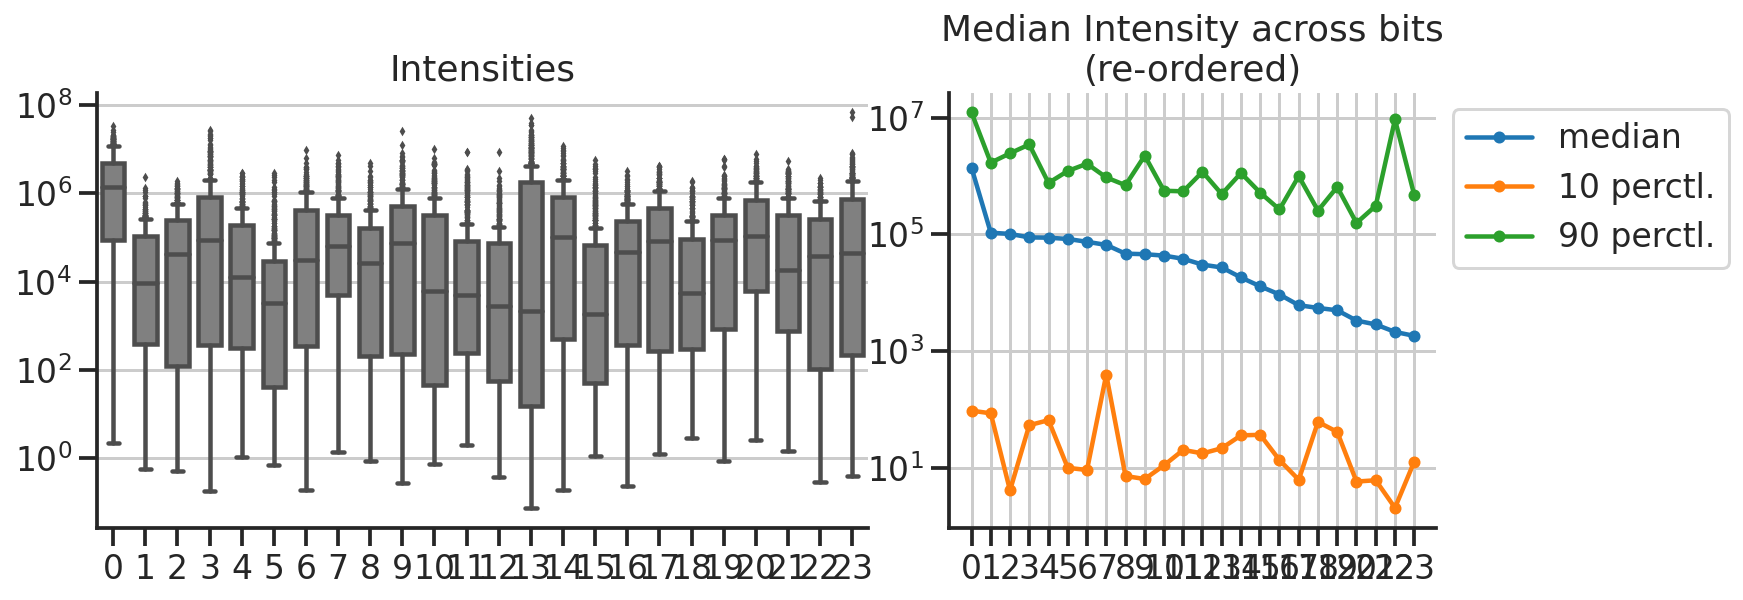

In [14]:
plot_intn(prjx)

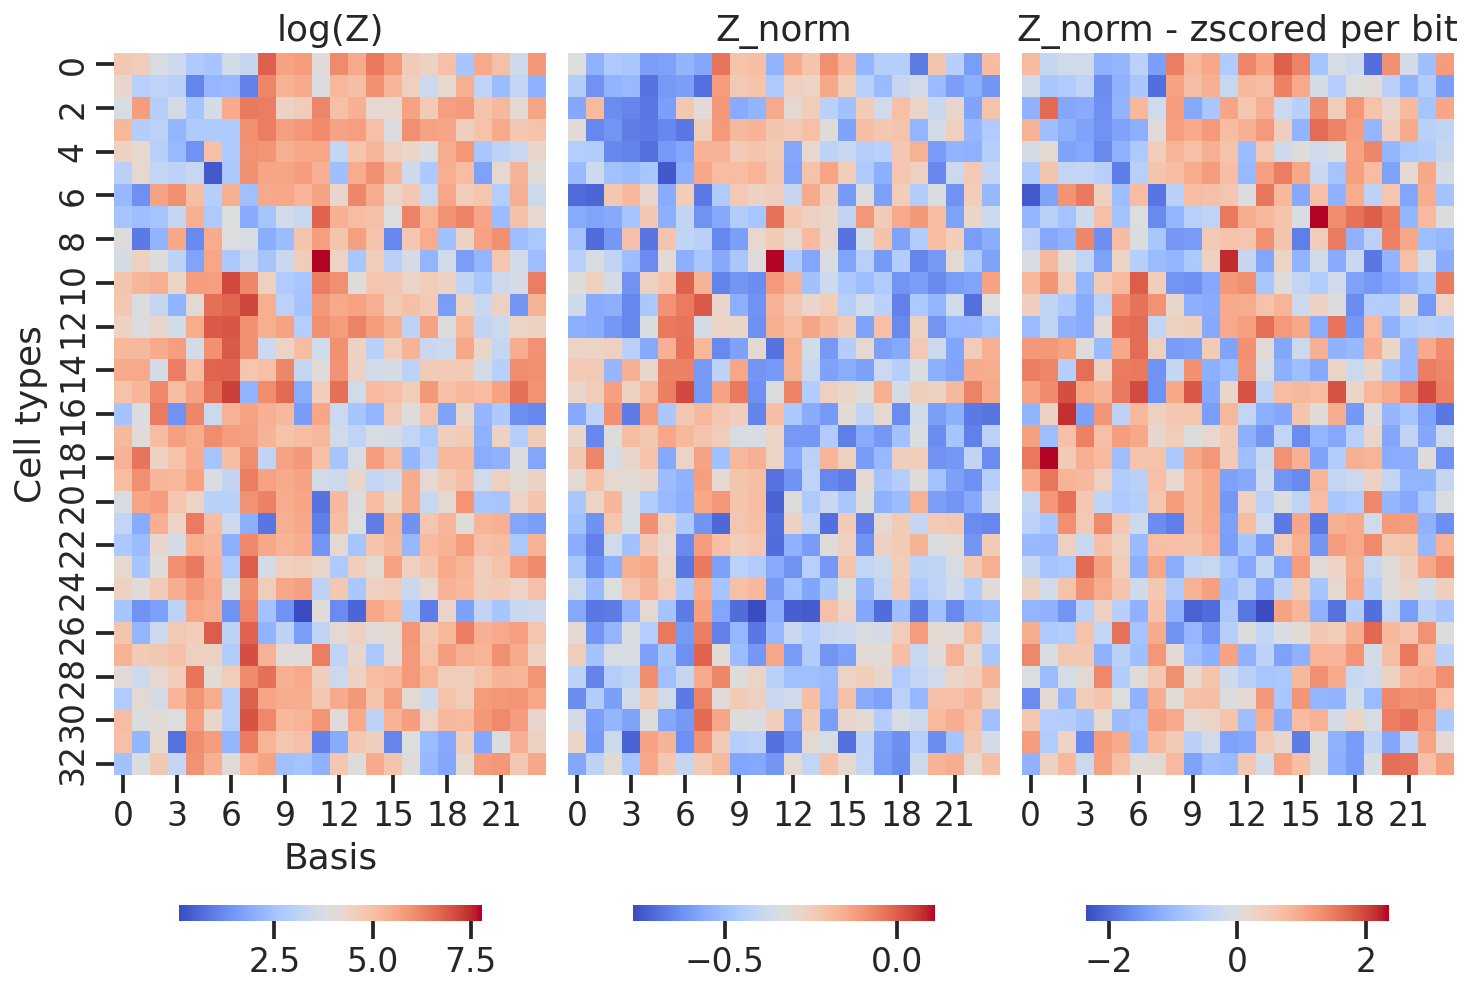

In [15]:
plot_embx_clsts(prjx_clsts, embx_clsts, embx_clsts_z, _rows, _cols)

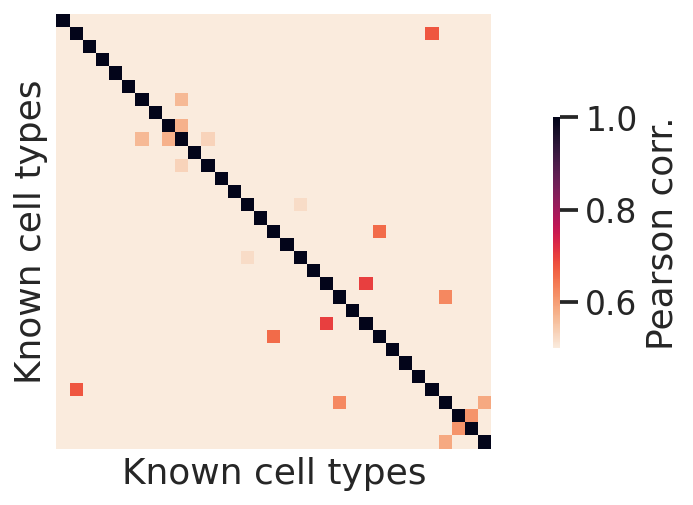

In [16]:
plot_heatcorr(embx_clsts_corr)